<a href="https://colab.research.google.com/github/yashgupta-7/689_project/blob/main/professions_neuron_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
%cd /content/gdrive/MyDrive/cs689_project
!ls

/content/gdrive/MyDrive/cs689_project
professions_data  results  winobias_data  winobias.py  winogender_data


In [3]:
!pip install transformers==3.2.0

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 35.0 MB/s 
     |████████████████████████████████| 3.0 MB 39.3 MB/s 
     |████████████████████████████████| 1.2 MB 22.9 MB/s 


In [4]:
model_name = "gpt2"
device = "cuda"
out_dir = "."
professions_file = "professions_data/professions.json"
templates = [
        "The {} said that",
        "The {} yelled that",
        "The {} whispered that",
        "The {} wanted that",
        "The {} desired that",
        "The {} wished that",
        "The {} ate because",
        "The {} ran because",
        "The {} drove because",
        "The {} slept because",
        "The {} cried because",
        "The {} laughed because",
        "The {} went home because",
        "The {} stayed up because",
        "The {} was fired because",
        "The {} was promoted because",
        "The {} yelled because",
    ]
intervention_types = [
        "man_direct",
        "man_indirect",
        "woman_direct",
        "woman_indirect",
    ]

In [5]:
professions_list = []
import json
with open(professions_file, 'r') as profs_f:
  profs_json = json.load(profs_f)
  profs_list = [prof[0] for prof in profs_json]
print("Number of Professions", len(profs_list))

Number of Professions 320


In [6]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm
from functools import partial


class Model():
  def __init__(self,
               device='cpu',
               output_attentions=False,
               random_weights=False,
               gpt2_version='gpt2'):
        super()
        self.device = device
        self.model = GPT2LMHeadModel.from_pretrained(gpt2_version, output_attentions=output_attentions)
        self.model.eval()
        self.model.to(device)
        if random_weights:
            print('Randomizing weights')
            self.model.init_weights()
        tokenizer = GPT2Tokenizer.from_pretrained(gpt2_version)

        self.attention_layer = lambda layer: self.model.transformer.h[layer].attn
        self.word_emb_layer = self.model.transformer.wte
        self.neuron_layer = lambda layer: self.model.transformer.h[layer].mlp

        self.num_layers = self.model.config.num_hidden_layers
        self.num_neurons = self.model.config.hidden_size
        self.num_heads = self.model.config.num_attention_heads
  
  def get_representations(self, context, position):
        # Hook for saving the representation
        def extract_representation_hook(module,
                                        input,
                                        output,
                                        position,
                                        representations,
                                        layer):
            representations[layer] = output[(0, position)]
        
        handles = []
        representation = {}
        with torch.no_grad():
            # construct all the hooks
            # word embeddings will be layer -1
            handles.append(self.word_emb_layer.register_forward_hook(
                partial(extract_representation_hook,
                        position=position,
                        representations=representation,
                        layer=-1)))
            # hidden layers
            for layer in range(self.num_layers):
                handles.append(self.neuron_layer(layer).register_forward_hook(
                    partial(extract_representation_hook,
                            position=position,
                            representations=representation,
                            layer=layer)))
            self.model(context.unsqueeze(0))
            for h in handles:
                h.remove()
        # print(representation[0][:5])
        return representation
        
  def neuron_intervention_experiment(self,
                                       word2intervention,
                                       intervention_type,
                                       layers_to_adj=[],
                                       neurons_to_adj=[],
                                       alpha=1,
                                       intervention_loc='all'):
        word2intervention_results = {}
        for word in tqdm(word2intervention, desc='words'):
            word2intervention_results[word] = self.neuron_intervention_single_experiment(
                word2intervention[word], intervention_type, layers_to_adj, neurons_to_adj,
                alpha, intervention_loc=intervention_loc)

        return word2intervention_results
  
  def get_probabilities_for_examples(self, context, candidates):
        """Return probabilities of single-token candidates given context"""
        for c in candidates:
            if len(c) > 1:
                raise ValueError(f"Multiple tokens not allowed: {c}")
        outputs = [c[0] for c in candidates]
        logits = self.model(context)[0]
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        return probs[:, outputs].tolist()
  
  def neuron_intervention(self,
                            context,
                            outputs,
                            rep,
                            layers,
                            neurons,
                            position,
                            intervention_type='diff',
                            alpha=1.):
        def intervention_hook(module,
                              input,
                              output,
                              position,
                              neurons,
                              intervention,
                              intervention_type):
            neurons = torch.LongTensor(neurons).to(self.device)
            base_slice = (slice(None), position, slice(None))
            base = output[base_slice].gather(1, neurons)
            intervention_view = intervention.view_as(base)

            if intervention_type == 'replace':
                base = intervention_view
            elif intervention_type == 'diff':
                base += intervention_view
            else:
                raise ValueError(f"Invalid intervention_type: {intervention_type}")
            scatter_mask = torch.zeros_like(output, dtype=torch.bool)
            for i, v in enumerate(neurons):
                scatter_mask[(i, position, v)] = 1
            output.masked_scatter_(scatter_mask, base.flatten())

        # Set up the context as batch
        batch_size = len(neurons)
        context = context.unsqueeze(0).repeat(batch_size, 1)
        handle_list = []
        for layer in set(layers):
            neuron_loc = np.where(np.array(layers) == layer)[0]
            n_list = []
            for n in neurons:
                unsorted_n_list = [n[i] for i in neuron_loc]
                n_list.append(list(np.sort(unsorted_n_list)))
            intervention_rep = alpha * rep[layer][n_list]
            if layer == -1:
                handle_list.append(self.word_emb_layer.register_forward_hook(
                    partial(intervention_hook,
                            position=position,
                            neurons=n_list,
                            intervention=intervention_rep,
                            intervention_type=intervention_type)))
            else:
                handle_list.append(self.neuron_layer(layer).register_forward_hook(
                    partial(intervention_hook,
                            position=position,
                            neurons=n_list,
                            intervention=intervention_rep,
                            intervention_type=intervention_type)))
        new_probabilities = self.get_probabilities_for_examples(
            context,
            outputs)
        for hndle in handle_list:
            hndle.remove()
        return new_probabilities
  
  def neuron_intervention_single_experiment(self,
                                              intervention,
                                              intervention_type, layers_to_adj=[],
                                              neurons_to_adj=[],
                                              alpha=100,
                                              bsize=800, intervention_loc='all'):

        with torch.no_grad():
            '''
            Compute representations for base terms (one for each side of bias)
            '''
            base_representations = self.get_representations(
                intervention.base_strings_tok[0],
                intervention.position)
            man_representations = self.get_representations(
                intervention.base_strings_tok[1],
                intervention.position)
            woman_representations = self.get_representations(
                intervention.base_strings_tok[2],
                intervention.position)

            # TODO: this whole logic can probably be improved
            # determine effect type and set representations

            # e.g. The teacher said that
            if intervention_type == 'man_minus_woman':
                context = intervention.base_strings_tok[0]
                rep = {k: v - woman_representations[k]
                       for k, v in man_representations.items()}
                replace_or_diff = 'diff'
            # e.g. The teacher said that
            elif intervention_type == 'woman_minus_man':
                context = intervention.base_strings_tok[0]
                rep = {k: v - man_representations[k]
                       for k, v in woman_representations.items()}
                replace_or_diff = 'diff'
            # e.g. The man said that
            elif intervention_type == 'man_direct':
                context = intervention.base_strings_tok[1]
                rep = base_representations
                replace_or_diff = 'replace'
            # e.g. The teacher said that
            elif intervention_type == 'man_indirect':
                context = intervention.base_strings_tok[0]
                rep = man_representations
                replace_or_diff = 'replace'
            # e.g. The woman said that
            elif intervention_type == 'woman_direct':
                context = intervention.base_strings_tok[2]
                rep = base_representations
                replace_or_diff = 'replace'
            # e.g. The teacher said that
            elif intervention_type == 'woman_indirect':
                context = intervention.base_strings_tok[0]
                rep = woman_representations
                replace_or_diff = 'replace'
            else:
                raise ValueError(f"Invalid intervention_type: {intervention_type}")

            # Probabilities without intervention (Base case)
            candidate1_base_prob, candidate2_base_prob = self.get_probabilities_for_examples(
                intervention.base_strings_tok[0].unsqueeze(0),
                intervention.candidates_tok)[0]
            candidate1_alt1_prob, candidate2_alt1_prob = self.get_probabilities_for_examples(
                intervention.base_strings_tok[1].unsqueeze(0),
                intervention.candidates_tok)[0]
            candidate1_alt2_prob, candidate2_alt2_prob = self.get_probabilities_for_examples(
                intervention.base_strings_tok[2].unsqueeze(0),
                intervention.candidates_tok)[0]
            # Now intervening on potentially biased example
            if intervention_loc == 'all':
              candidate1_probs = torch.zeros((self.num_layers + 1, self.num_neurons))
              candidate2_probs = torch.zeros((self.num_layers + 1, self.num_neurons))

              for layer in range(-1, self.num_layers):
                for neurons in batch(range(self.num_neurons), bsize):
                    neurons_to_search = [[i] + neurons_to_adj for i in neurons]
                    layers_to_search = [layer] + layers_to_adj

                    probs = self.neuron_intervention(
                        context=context,
                        outputs=intervention.candidates_tok,
                        rep=rep,
                        layers=layers_to_search,
                        neurons=neurons_to_search,
                        position=intervention.position,
                        intervention_type=replace_or_diff,
                        alpha=alpha)
                    for neuron, (p1, p2) in zip(neurons, probs):
                        candidate1_probs[layer + 1][neuron] = p1
                        candidate2_probs[layer + 1][neuron] = p2
                        # Now intervening on potentially biased example
            elif intervention_loc == 'layer':
              layers_to_search = (len(neurons_to_adj) + 1)*[layers_to_adj]
              candidate1_probs = torch.zeros((1, self.num_neurons))
              candidate2_probs = torch.zeros((1, self.num_neurons))

              for neurons in batch(range(self.num_neurons), bsize):
                neurons_to_search = [[i] + neurons_to_adj for i in neurons]

                probs = self.neuron_intervention(
                    context=context,
                    outputs=intervention.candidates_tok,
                    rep=rep,
                    layers=layers_to_search,
                    neurons=neurons_to_search,
                    position=intervention.position,
                    intervention_type=replace_or_diff,
                    alpha=alpha)
                for neuron, (p1, p2) in zip(neurons, probs):
                    candidate1_probs[0][neuron] = p1
                    candidate2_probs[0][neuron] = p2
            else:
              probs = self.neuron_intervention(
                        context=context,
                        outputs=intervention.candidates_tok,
                        rep=rep,
                        layers=layers_to_adj,
                        neurons=neurons_to_adj,
                        position=intervention.position,
                        intervention_type=replace_or_diff,
                        alpha=alpha)
              for neuron, (p1, p2) in zip(neurons_to_adj, probs):
                  candidate1_probs = p1
                  candidate2_probs = p2


        return (candidate1_base_prob, candidate2_base_prob,
                candidate1_alt1_prob, candidate2_alt1_prob,
                candidate1_alt2_prob, candidate2_alt2_prob,
                candidate1_probs, candidate2_probs)

In [7]:
random_weights = False
model = Model(device=device, gpt2_version=model_name, random_weights=random_weights)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [8]:
class Intervention():
       def __init__(self,
                  tokenizer,
                  base_string: str,
                  substitutes: list,
                  candidates: list,
                  device='cpu'):
          super()
          self.device = device
          self.enc = tokenizer

          # First item should be neutral, others tainted
          self.base_strings = [base_string.format(s)
                              for s in substitutes]
          # Tokenized bases
          self.base_strings_tok = [
              self.enc.encode(s,
                              add_special_tokens=False)
              for s in self.base_strings
          ]
          # print(self.base_strings, self.base_strings_tok)
          self.base_strings_tok = torch.LongTensor(self.base_strings_tok)\
                                      .to(device)
          self.position = base_string.split().index('{}')
          self.candidates = []
          for c in candidates:
              # 'a ' added to input so that tokenizer understand that first word follows a space.
              tokens = self.enc.tokenize(
                  'a ' + c)[1:]
              self.candidates.append(tokens)

          self.candidates_tok = [self.enc.convert_tokens_to_ids(tokens)
                                for tokens in self.candidates]

def construct_interventions(base_sent, professions, tokenizer, DEVICE):
    interventions = {}
    unused = 0
    for p in professions:
      try:
        interventions[p] = Intervention(tokenizer, base_sent, [p, "man", "woman"], ["he", "she"], device=DEVICE)
      except:
        unused += 1
    print("Unused Professions", unused)
    return interventions

In [9]:
import torch
import torch.nn.functional as F
import numpy as np
from datetime import datetime
import os
from copy import deepcopy

import pandas as pd


def batch(iterable, bsize=1):
    total_len = len(iterable)
    for ndx in range(0, total_len, bsize):
        yield list(iterable[ndx : min(ndx + bsize, total_len)])
def convert_results_to_pd(
    interventions, intervention_results, layer_fixed=None, neuron_fixed=None
):
    """
    Convert intervention results to data frame
    Args:
        interventions: dictionary from word (e.g., profession) to intervention
        intervention_results: dictionary from word to intervention results
    """

    results = []
    for word in intervention_results:
        intervention = interventions[word]
        (
            candidate1_base_prob,
            candidate2_base_prob,
            candidate1_alt1_prob,
            candidate2_alt1_prob,
            candidate1_alt2_prob,
            candidate2_alt2_prob,
            candidate1_probs,
            candidate2_probs,
        ) = intervention_results[word]
        # we have results for all layers and all neurons
        results_base = {  # strings
            "word": word,
            "base_string": intervention.base_strings[0],
            "alt_string1": intervention.base_strings[1],
            "alt_string2": intervention.base_strings[2],
            "candidate1": intervention.candidates[0],
            "candidate2": intervention.candidates[1],
            # base probs
            "candidate1_base_prob": float(candidate1_base_prob),
            "candidate2_base_prob": float(candidate2_base_prob),
            "candidate1_alt1_prob": float(candidate1_alt1_prob),
            "candidate2_alt1_prob": float(candidate2_alt1_prob),
            "candidate1_alt2_prob": float(candidate1_alt2_prob),
            "candidate2_alt2_prob": float(candidate2_alt2_prob),
        }
        if layer_fixed is None:
            for layer in range(candidate1_probs.size(0)):
                for neuron in range(candidate1_probs.size(1)):
                    c1_prob, c2_prob = (
                        candidate1_probs[layer][neuron],
                        candidate2_probs[layer][neuron],
                    )
                    results_single = deepcopy(results_base)
                    results_single.update(
                        {  # strings
                            # intervention probs
                            "candidate1_prob": float(c1_prob),
                            "candidate2_prob": float(c2_prob),
                            "layer": layer,
                            "neuron": neuron,
                        }
                    )
                    results.append(results_single)
        # we have results for all neurons in one layer
        elif neuron_fixed is None:
            for neuron in range(candidate1_probs.size(1)):
                c1_prob, c2_prob = (
                    candidate1_probs[0][neuron],
                    candidate2_probs[0][neuron],
                )
                results_single = deepcopy(results_base)
                results_single.update(
                    {  # strings
                        # intervention probs
                        "candidate1_prob": float(c1_prob),
                        "candidate2_prob": float(c2_prob),
                        "layer": layer_fixed,
                        "neuron": neuron,
                    }
                )
                results.append(results_single)
        # we have result for a specific neuron and layer
        else:
            c1_prob, c2_prob = candidate1_probs, candidate2_probs
            results_single = deepcopy(results_base)
            results_single.update(
                {  # strings
                    # intervention probs
                    "candidate1_prob": float(c1_prob),
                    "candidate2_prob": float(c2_prob),
                    "layer": layer_fixed,
                    "neuron": neuron_fixed,
                }
            )
            results.append(results_single)
    return pd.DataFrame(results)

dt_string = datetime.now().strftime("%Y%m%d")
folder_name = dt_string + "_neuron_intervention"
base_path = os.path.join(out_dir, "results", folder_name)
os.mkdir(base_path)
for temp in templates:
        print("Running template '{}' now...".format(temp), flush=True)
        # Fill in all professions into current template
        interventions = construct_interventions(temp, profs_list, tokenizer, device)
        # print(interventions)
        for itype in intervention_types:
            print("\t Running with intervention: {}".format(itype), flush=True)
            # Run actual exp.
            intervention_results = model.neuron_intervention_experiment(
                interventions, itype, alpha=1.0
            )

            df = convert_results_to_pd(interventions, intervention_results)
            # Generate file name.
            temp_string = "_".join(temp.replace("{}", "X").split())
            model_type_string = model_name
            fname = "_".join([temp_string, itype, model_type_string])
            # Finally, save each exp separately.
            df.to_csv(os.path.join(base_path, fname + ".csv"))

Running template 'The {} said that' now...
Unused Professions 151
	 Running with intervention: man_direct


words: 100%|██████████| 169/169 [19:05<00:00,  6.78s/it]


	 Running with intervention: man_indirect


words: 100%|██████████| 169/169 [19:06<00:00,  6.78s/it]


	 Running with intervention: woman_direct


words: 100%|██████████| 169/169 [19:05<00:00,  6.78s/it]


	 Running with intervention: woman_indirect


words:  47%|████▋     | 80/169 [09:02<10:03,  6.78s/it]


KeyboardInterrupt: ignored

In [5]:
folder_name = "results/20211119_neuron_intervention/"
model_name = "distilgpt2"

In [7]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr


def compute_total_effect(row):
    """Compute the total effect based on the bias directionality."""
    if row["base_c1_effect"] >= 1.0:
        return row["alt1_effect"] / row["base_c1_effect"]
    else:
        return row["alt2_effect"] / row["base_c2_effect"]


def filtered_mean(df, column_name, profession_stereotypicality, model_name):
    """Get the mean effects after excluding strictly definitional professions."""

    def get_profession(s):
        # Discard PADDING TEXT used in XLNet
        if model_name.startswith('xlnet'): s = s.split('<eos>')[-1]
        return s.split()[1]

    def get_stereotypicality(vals):
        return abs(profession_stereotypicality[vals]["definitional"])

    df["profession"] = df["base_string"].apply(get_profession)
    df["definitional"] = df["profession"].apply(get_stereotypicality)
    return df[df["definitional"] < 0.75][column_name].mean()

The total effect of this model is 2.237
The total (male) effect of this model is 3.080
The total (female) effect of this model is 48.186


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


The correlation between bias value and (log) effect is 0.60 (p=0.000)


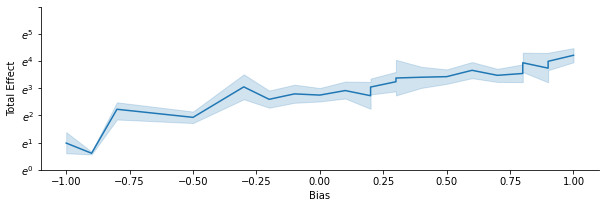

In [8]:
profession_stereotypicality = {}
with open("professions_data/professions.json") as f:
    for l in f:
        for p in eval(l):
            profession_stereotypicality[p[0]] = {
                "stereotypicality": p[2],
                "definitional": p[1],
                "total": p[2] + p[1],
                "max": max([p[2], p[1]], key=abs),
            }

fnames = [
    f
    for f in os.listdir(folder_name)
    if "_" + model_name + ".csv" in f and f.endswith("csv")
]
paths = [os.path.join(folder_name, f) for f in fnames]
# fnames[:5], paths[:5]
woman_files = [
    f
    for f in paths
    if "woman_indirect" in f
    if os.path.exists(f.replace("indirect", "direct"))
]

means = []
he_means = []
she_means = []
# For correlations.
all_female_effects = []
for path in woman_files:
    temp_df = pd.read_csv(path).groupby("base_string").agg("mean").reset_index()
    temp_df["alt1_effect"] = (
        temp_df["candidate1_alt1_prob"] / temp_df["candidate2_alt1_prob"]
    )
    temp_df["alt2_effect"] = (
        temp_df["candidate2_alt2_prob"] / temp_df["candidate1_alt2_prob"]
    )
    temp_df["base_c1_effect"] = (
        temp_df["candidate1_base_prob"] / temp_df["candidate2_base_prob"]
    )
    temp_df["base_c2_effect"] = (
        temp_df["candidate2_base_prob"] / temp_df["candidate1_base_prob"]
    )
    temp_df["he_total_effect"] = temp_df["alt1_effect"] / temp_df["base_c1_effect"]
    temp_df["she_total_effect"] = temp_df["alt2_effect"] / temp_df["base_c2_effect"]
    temp_df["total_effect"] = temp_df.apply(compute_total_effect, axis=1)

    mean_he_total = filtered_mean(
        temp_df, "he_total_effect", profession_stereotypicality, model_name
    )
    mean_she_total = filtered_mean(
        temp_df, "she_total_effect", profession_stereotypicality, model_name
    )
    mean_total = filtered_mean(
        temp_df, "total_effect", profession_stereotypicality, model_name
    )
    he_means.append(mean_he_total)
    she_means.append(mean_she_total)
    means.append(mean_total)
    all_female_effects.append(temp_df[["base_string", "she_total_effect"]])

print("The total effect of this model is {:.3f}".format(np.mean(means) - 1))
print(
    "The total (male) effect of this model is {:.3f}".format(np.mean(he_means) - 1)
)
print(
    "The total (female) effect of this model is {:.3f}".format(
        np.mean(she_means) - 1
    )
)

# Part 2: Get correlations.

all_female_total_effects = pd.concat(all_female_effects)
all_female_total_effects = all_female_total_effects.rename(
    columns={"she_total_effect": "total_effect"}
)
x_vals = []
y_vals = []
labels = []
for index, row in all_female_total_effects.iterrows():
    labels.append(row["base_string"])
    y_vals.append(row["total_effect"])
    x_vals.append(
        profession_stereotypicality[
            row["base_string"].split()[1] if not model_name.startswith('xlnet')
            else row["base_string"].split('<eos>')[-1].split()[1]
        ]["total"]
    )
profession_df = pd.DataFrame(
    {"example": labels, "Bias": x_vals, "Total Effect": np.log(y_vals)}
)
plt.figure(figsize=(10, 3))
ax = sns.lineplot(
    "Bias", "Total Effect", data=profession_df, markers=True, dashes=True
)
ax.set_yticks([0, 1, 2, 3, 4, 5, 6])
ax.set_yticklabels(["$e^0$", "$e^1$", "$e^2$", "$e^3$", "$e^4$", "$e^5$"])
sns.despine()
plt.savefig(os.path.join(folder_name, "neuron_profession_correlation.pdf"))

effect_corr = pearsonr(profession_df["Bias"], profession_df["Total Effect"])
print("================")
print(
    "The correlation between bias value and (log) effect is {:.2f} (p={:.3f})".format(
        effect_corr[0], effect_corr[1]
    )
)

In [9]:
male_means_model = []
female_means_model = []

male_means_def = []
female_means_def = []
for path in woman_files:
    df = pd.read_csv(path).groupby("base_string").agg("mean").reset_index()

    def get_profession(s):
        # Discard PADDING TEXT used in XLNet
        if model_name.startswith('xlnet'): s = s.split('<eos>')[-1]
        return s.split()[1]

    # Set up filtering by stereotypicality
    def get_definitionality(vals):
        return abs(profession_stereotypicality[vals]["definitional"])

    def get_stereotypicality(vals):
        return profession_stereotypicality[vals]["total"]

    df["profession"] = df["base_string"].apply(get_profession)
    df["definitional"] = df["profession"].apply(get_definitionality)
    df["stereotypicality"] = df["profession"].apply(get_stereotypicality)
    """
    FILTERING
    """
    # Remove examples that are too definitional
    df = df[df["definitional"] < 0.75]
    # Ignore outliers with < 1% for he or she
    df = df[df["candidate1_base_prob"] > 0.01]
    df = df[df["candidate2_base_prob"] > 0.01]
    """
    TOTAL EFFECTS
    """
    # Compute base_ratios for man (he/she) and woman (she/he)
    df["man_he_she_effect"] = (
        df["candidate1_alt1_prob"] / df["candidate2_alt1_prob"]
    )
    df["woman_she_he_effect"] = (
        df["candidate2_alt2_prob"] / df["candidate1_alt2_prob"]
    )
    # Compute profession effect
    df["base_he_she_effect"] = (
        df["candidate1_base_prob"] / df["candidate2_base_prob"]
    )
    df["base_she_he_effect"] = (
        df["candidate2_base_prob"] / df["candidate1_base_prob"]
    )
    # Compute both directions total effect
    df["he_she_total_effect"] = df["man_he_she_effect"] / df["base_he_she_effect"]
    df["she_he_total_effect"] = df["woman_she_he_effect"] / df["base_she_he_effect"]

    """
    Compute the effects of:
    male -> woman | she/he
    female -> man | he/she
    """

    # (1) Filter by model direction
    female_mean_model = df[df["base_she_he_effect"] > 1.0][
        "he_she_total_effect"
    ].values
    female_means_model.extend(female_mean_model)

    male_mean_model = df[df["base_he_she_effect"] > 1.0][
        "she_he_total_effect"
    ].values
    male_means_model.extend(male_mean_model)

    # (2) Filter by stereotype
    female_mean_def = df[df["stereotypicality"] < 0.0]["he_she_total_effect"].values
    female_means_def.extend(female_mean_def)

    male_mean_def = df[df["stereotypicality"] > 0.0]["she_he_total_effect"].values
    male_means_def.extend(male_mean_def)

# print("The total effect of this model is {:.3f}".format(np.mean(means)-1))
print(
    "The total (female profession (model) -> man) effect of this model is {:.3f}".format(
        np.mean(male_means_model) - 1
    )
)
print(
    "The total (male profession (model) -> woman) effect of this model is {:.3f}".format(
        np.mean(female_means_model) - 1
    )
)
print(
    "The combined effect is {:.3f}".format(
        np.mean(female_means_model + male_means_model) - 1
    )
)

print(
    "The total (female profession (def) -> man) effect of this model is {:.3f}".format(
        np.mean(male_means_def) - 1
    )
)
print(
    "The total (male profession (def) -> woman) effect of this model is {:.3f}".format(
        np.mean(female_means_def) - 1
    )
)
print(
    "The combined effect is {:.3f}".format(
        np.mean(female_means_def + male_means_def) - 1
    )
)

The total (female profession (model) -> man) effect of this model is 38.551
The total (male profession (model) -> woman) effect of this model is 21.055
The combined effect is 37.606
The total (female profession (def) -> man) effect of this model is 42.715
The total (male profession (def) -> woman) effect of this model is 9.099
The combined effect is 36.381
